# **Introduction**

In this notebook using **CNN** and concept of **Transfer Learning** to perform Image classification on *Diabetic Retinopathy* dataset. <br>
Since dataset is small **Transfer Learning** is really helpful to perfom **Image classification**.

# Explaining *Diabetic Retinopathy*

Diabetic retinopathy, also known as diabetic eye disease (DED), is a medical condition in which damage occurs to the retina due to diabetes mellitus. <br>It is a leading cause of blindness in developed countries.


__In this dataset there 5 clsasses__
1. Healthy - 1000 images
2. Mild DR - 370 images
3. Moderate DR - 900 images
4. Profilate DR - 290 images
5. Severe DR - 190 images
*DR: Diabetic Retinopathy* <br>
*In total 2750 images*

# Importing libraries

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import cv2
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tqdm import tqdm
import os
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import EfficientNetB2
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, TensorBoard, ModelCheckpoint
from sklearn.metrics import classification_report,confusion_matrix
import ipywidgets as widgets
import io
from PIL import Image
from IPython.display import display,clear_output
from warnings import filterwarnings
import pathlib

from tensorflow import keras
from tensorflow.keras import layers

from glob import glob
from keras.models import Sequential,Model
from keras.utils.vis_utils import plot_model
import warnings
warnings.filterwarnings('ignore')

# Data preparation and some visualisation

In [2]:
data_dir = pathlib.Path('../input/diabetic-retinopathy-dataset')

image_count = len(list(data_dir.glob('*/*')))
print(image_count)

2750


In [3]:
severity_labels = [name for name in os.listdir(data_dir) if os.path.isdir(os.path.join(data_dir, name))]

batch = 32
image_width = 256
image_height = 256

## Resizing data and loading into numpy arrays

In [4]:
X_train = []
y_train = []

for j in severity_labels:
        folderPath = os.path.join(data_dir,j)
        for k in tqdm(os.listdir(folderPath)):
            img = cv2.imread(os.path.join(folderPath,k))
            img = cv2.resize(img, (image_width,image_height))
            X_train.append(img)
            y_train.append(j)
            
X_train = np.array(X_train)
y_train = np.array(y_train)

100%|██████████| 290/290 [00:02<00:00, 128.65it/s]


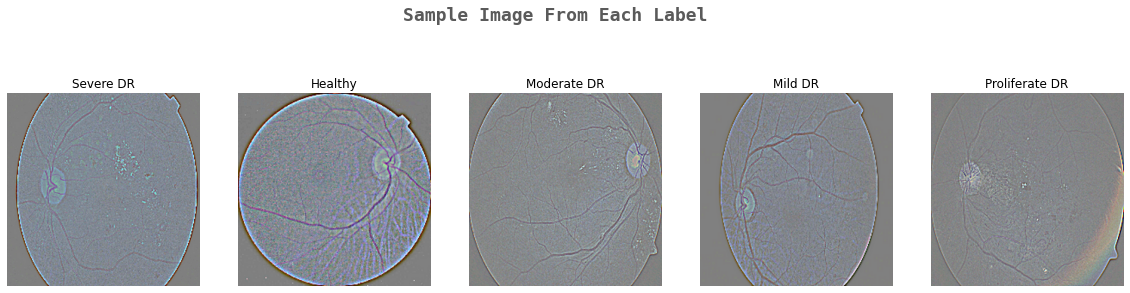

In [5]:
k=0
fig, ax = plt.subplots(1,5,figsize=(20,20))
fig.text(s='Sample Image From Each Label',size=18,fontweight='bold',
             fontname='monospace',color="#313131",y=0.62,x=0.4,alpha=0.8)

for i in severity_labels:
    j=0
    while True :
        if y_train[j]==i:
            ax[k].imshow(X_train[j])
            ax[k].set_title(y_train[j])
            ax[k].axis('off')
            k+=1
            break
        j+=1

## Shuffling data and spliting into **training** and **testing** sets

In [6]:
X_train, y_train = shuffle(X_train,y_train, random_state=101)

In [7]:
X_train.shape
y_train.shape

(2750,)

In [8]:
X_train,X_test,y_train,y_test = train_test_split(X_train,y_train, test_size=0.1,random_state=101)

Performing **One Hot Encoding** on labels. <br>
**One Hot Encoding** converts categorical data into numeric values.

In [9]:
y_train_new = []
for i in y_train:
    y_train_new.append(severity_labels.index(i))
y_train = y_train_new
y_train = tf.keras.utils.to_categorical(y_train)

y_test_new = []
for i in y_test:
    y_test_new.append(severity_labels.index(i))
y_test = y_test_new
y_test = tf.keras.utils.to_categorical(y_test)

In [ ]:
print(y_test)

# Transfer learning
In this notebook for training we are using **Transfer Learning** concept <br>

I will be using **EfficientNetB2** model with weights from **imagenet**. <br>
And I will using **include_top=False** option since it allows me to add my own output layer. <br>
**EfficientNetB2** model is used because *image size is 256x256*

The original image sizes used for every version of EfficientNet are:

    EfficientNetB0 - (224, 224, 3)
    EfficientNetB1 - (240, 240, 3)
    EfficientNetB2 - (260, 260, 3)
    EfficientNetB3 - (300, 300, 3)
    EfficientNetB4 - (380, 380, 3)
    EfficientNetB5 - (456, 456, 3)
    EfficientNetB6 - (528, 528, 3)
    EfficientNetB7 - (600, 600, 3)


In [10]:
effnet = EfficientNetB2(weights='imagenet',include_top=False,input_shape=(image_height,image_width,3))

31801344/31790344 [==============================] - 2s 0us/step


## Modifying model output layers by adding dropout layers and kernel regularizer '*L2'*

In [11]:
model = effnet.output
model = tf.keras.layers.GlobalAveragePooling2D()(model)
model = tf.keras.layers.Dense(128,activation='tanh', kernel_regularizer='l2')(model)
model = tf.keras.layers.Dropout(rate=0.5)(model)
model = tf.keras.layers.Dense(64,activation='tanh', kernel_regularizer='l2')(model)
model = tf.keras.layers.Dropout(rate=0.3)(model)
model = tf.keras.layers.Dense(32,activation='tanh', kernel_regularizer='l2')(model)
model = tf.keras.layers.Dropout(rate=0.5)(model)
model = tf.keras.layers.Dense(5,activation='softmax')(model)
model = tf.keras.models.Model(inputs=effnet.input, outputs = model)

In [12]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
rescaling (Rescaling)           (None, 256, 256, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
normalization (Normalization)   (None, 256, 256, 3)  7           rescaling[0][0]                  
__________________________________________________________________________________________________
stem_conv_pad (ZeroPadding2D)   (None, 257, 257, 3)  0           normalization[0][0]              
______________________________________________________________________________________________

In [13]:
model.compile(loss='categorical_crossentropy',optimizer = 'Adam', metrics= ['accuracy'])

## Writing callback functions to help with model debugging <br>and reducing learning rate when model reach *Plateau*

In [14]:
tensorboard = TensorBoard(log_dir = 'logs')
checkpoint = ModelCheckpoint("effnet.h5",monitor="val_accuracy",save_best_only=True,mode="auto",verbose=1)
reduce_lr = ReduceLROnPlateau(monitor = 'val_accuracy', factor = 0.3, patience = 2, min_delta = 0.001,
                              mode='auto',verbose=1)
early_stop=EarlyStopping(monitor='val_loss', restore_best_weights= True, patience=5, verbose=1)

callback_options = [tensorboard,checkpoint,reduce_lr,early_stop]

In [15]:
history = model.fit(X_train,y_train,validation_split =0.1, epochs =15, verbose =1, batch_size =32,
                   callbacks = callback_options)

Epoch 1/15
70/70 [==============================] - 386s 5s/step - loss: 4.1909 - accuracy: 0.5842 - val_loss: 4.1134 - val_accuracy: 0.5121

Epoch 00001: val_accuracy improved from -inf to 0.51210, saving model to effnet.h5
Epoch 2/15
70/70 [==============================] - 364s 5s/step - loss: 2.8106 - accuracy: 0.6839 - val_loss: 3.0676 - val_accuracy: 0.5040

Epoch 00002: val_accuracy did not improve from 0.51210
Epoch 3/15
70/70 [==============================] - 360s 5s/step - loss: 1.9801 - accuracy: 0.7476 - val_loss: 2.3056 - val_accuracy: 0.6129

Epoch 00003: val_accuracy improved from 0.51210 to 0.61290, saving model to effnet.h5
Epoch 4/15
70/70 [==============================] - 363s 5s/step - loss: 1.5246 - accuracy: 0.7539 - val_loss: 1.8949 - val_accuracy: 0.6331

Epoch 00004: val_accuracy improved from 0.61290 to 0.63306, saving model to effnet.h5
Epoch 5/15
70/70 [==============================] - 360s 5s/step - loss: 1.1917 - accuracy: 0.7943 - val_loss: 1.5329 - va

In [16]:
model.save('Diabetic_Retinopathy_model.h5')

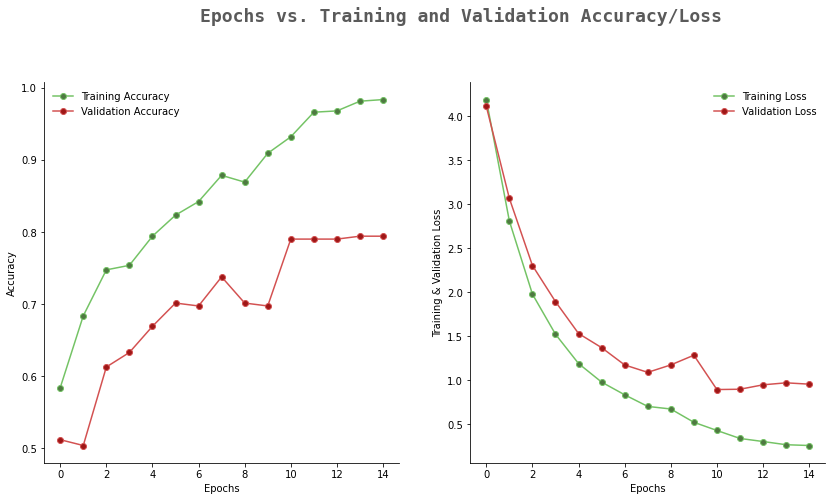

In [17]:
colors_dark = ["#1F1F1F", "#313131", '#636363', '#AEAEAE', '#DADADA']
colors_red = ["#331313", "#582626", '#9E1717', '#D35151', '#E9B4B4']
colors_green = ['#01411C','#4B6F44','#4F7942','#74C365','#D0F0C0']

n_epochs = len(history.history['loss'])    
epochs = [i for i in range(n_epochs)]
fig, ax = plt.subplots(1,2,figsize=(14,7))
train_acc = history.history['accuracy']
train_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']

fig.text(s='Epochs vs. Training and Validation Accuracy/Loss',size=18,fontweight='bold',
             fontname='monospace',color=colors_dark[1],y=1,x=0.28,alpha=0.8)

sns.despine()
ax[0].plot(epochs, train_acc, marker='o',markerfacecolor=colors_green[2],color=colors_green[3],
           label = 'Training Accuracy')
ax[0].plot(epochs, val_acc, marker='o',markerfacecolor=colors_red[2],color=colors_red[3],
           label = 'Validation Accuracy')
ax[0].legend(frameon=False)
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Accuracy')

sns.despine()
ax[1].plot(epochs, train_loss, marker='o',markerfacecolor=colors_green[2],color=colors_green[3],
           label ='Training Loss')
ax[1].plot(epochs, val_loss, marker='o',markerfacecolor=colors_red[2],color=colors_red[3],
           label = 'Validation Loss')
ax[1].legend(frameon=False)
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Training & Validation Loss')

fig.show()

# Prediction

In [18]:
pred = model.predict(X_test)
pred = np.argmax(pred,axis=1)
y_test_new = np.argmax(y_test,axis=1)

In [19]:
print(classification_report(y_test_new,pred))

              precision    recall  f1-score   support

           0       0.28      0.24      0.26        21
           1       0.96      0.98      0.97        87
           2       0.71      0.80      0.75       102
           3       0.67      0.59      0.63        37
           4       0.74      0.50      0.60        28

    accuracy                           0.76       275
   macro avg       0.67      0.62      0.64       275
weighted avg       0.75      0.76      0.75       275



In [20]:
accuracy = np.sum(pred==y_test_new)/len(pred)
print("Accuracy on testing dataset: {:.3f}%".format(accuracy*100))

Accuracy on testing dataset: 75.636%


In [22]:
print(pred)

[1 1 2 2 2 2 3 2 2 1 3 3 1 3 3 1 2 3 2 1 2 3 3 1 2 2 3 2 2 2 3 2 1 0 2 0 1
 2 4 0 1 0 0 0 2 1 2 2 2 0 2 2 1 2 0 3 2 3 2 1 2 2 1 0 2 0 1 2 2 2 1 2 3 1
 2 2 0 2 1 3 1 1 1 1 1 1 2 2 4 1 3 4 3 1 1 2 1 3 3 4 1 1 0 2 2 4 2 4 2 2 3
 4 2 1 2 2 1 2 1 3 2 0 1 2 2 2 2 2 2 2 1 1 2 2 2 2 1 3 2 2 1 1 1 2 4 1 2 2
 2 1 1 1 1 1 2 1 0 4 2 2 2 1 2 2 1 2 2 2 1 2 1 1 1 2 2 2 2 2 2 2 2 1 3 2 4
 1 3 1 1 2 2 0 1 3 2 4 1 2 3 2 2 4 2 1 1 2 1 1 1 4 2 2 0 1 2 3 1 1 1 2 1 1
 4 2 1 2 4 1 1 2 2 3 1 1 2 1 3 2 2 0 1 1 2 2 0 3 2 3 1 4 2 1 1 2 2 1 2 1 2
 1 1 1 1 4 1 3 3 4 1 2 4 3 2 2 2]
